<a href="https://colab.research.google.com/github/kiyong21c/kaggle/blob/main/20220623_future-sales-predict-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 향후 판매량 예측
 - 과거 판매 데이터를 기반으로 향후 판매량 예측
 - 문제유형 : 회귀
 - 평가지표 : RMSE
 - 사용모델 : LightGBM
 - 훈련/테스트/샘플제출 데이터 이외 3가지 추가데이터

  > shops : 상점에 관한 추가 정보

  > items : 상품에 관한 추가 정보

  > items_categories : 상품분류에 관한 추가 정보

 - 주의 사항 : 각 상점의 상품별 월간 판매량(타깃값)은 0개에서 20개 사이여야 한다

## 탐색적 데이터 분석
 - 참고한 노트북 : http://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda

### 데이터 둘러보기
 - 병합 → 피처 요약표 제작

In [2]:
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/predict_future_sales/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

#### sales_train 데이터

In [3]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


 - date_block_num : 0은 2013년 1월, 1은 2013년 2월,...
 - 타깃값은 '월'별 판매량이므로 date 피처는 삭제
 - item_price는 날짜나 상점에 따라 달라질 수 있음
 - item_cnt_day : 당일 판매량
 - 타깃값 = date_block_num 피처의 값이 같은 데이터들의 item_cnt_day 값의 합

In [4]:
sales_train.info(show_counts=True) # show_counts : 비결측값 개수 표시 여부

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            2935849 non-null  object 
 1   date_block_num  2935849 non-null  int64  
 2   shop_id         2935849 non-null  int64  
 3   item_id         2935849 non-null  int64  
 4   item_price      2935849 non-null  float64
 5   item_cnt_day    2935849 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


 - 모든 피처에 결측값이 없다
 - 데이터가 300만개 가까이 되므로 메모리 사용량이 134MB로 크다
 - 메모리 사용량은 가능한 줄여야 작업속도가 빨라진다

 - 분석결과

  > 2013년 1월부터 2015년 10월까지 판매 내역이 시간순으로 기록(시계열 데이터)

  > 2013년 1월 부터 2015년 9월까지 판매내역을 훈련데이터로

  > 2015년 10월 판매내역을 검증데이터로

  > 앞 장에서는 여러 폴드로 나눴지만(OOF예측), 시계열 데이터에서 폴드로 나누면 과거와 미래가 뒤섞여 이용할 수 없다

#### shops 데이터

In [5]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


 - 상점명에서 새로운 피처를 추출할 수 있다(첫 단어는 상점이 위치한 도시)
 - shop_id 피처는 sales_train데이터에도 있으므로 이를 기준으로 병합

In [6]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


 - 상점은 60개만 있으며, 결측값은 없다

#### items 데이터

In [7]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


item_id 피처는 sales_train데이터에도 있으므로 이를 기준으로 병합

In [8]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


 - 상품은 22170개가 있으며, 결측값은 없다

#### item_categories 데이터

In [9]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


 - item_category_id피처는 sales_train에도 있으므로 이를 기준으로 병합
 - 상품명의 첫 단어는 대분류를 의미

In [10]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


 - 84개의 상품분류가 있으며, 결측값은 없다

#### 텍스트 데이터

In [11]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


 - 각 상점의 각 상품별 월간 판매량 예측 : 타깃값

#### 데이터 병합
 - sales_train, shops, items, item_categories 데이터는 특정 피처를 기준으로 병합 할 수 있음
 - 판다스의 merge() : 하나 이상의 열을 기준으로 DataFrame 행을 합쳐줌

In [12]:
train = sales_train.merge(shops, on='shop_id') # sales_train이 왼쪽으로, how='left' : default
train = train.merge(items, on='item_id')
train = train.merge(item_categories, on='item_category_id')

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,02.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,03.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,20.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,23.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


#### 피처 요약표 만들기
 - 데이터 타입, 결측값 개수, 고윳값 개수, 첫 번째 값, 두번째 값

In [13]:
def resumetable(df):
    print(f'데이터셋 형상 : {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index':'피처'})
    summary['결측값 개수'] = df.isnull().sum().values # isnull(): null인지 False/True, sum() : 컬럼별 합계, values : Series의 index제외하고 값만 → array
    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values

    return summary

resumetable(train)

데이터셋 형상 : (2935849, 10)


,피처,데이터,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값
0,date,object,0,1034,02.01.2013,02.01.2013
1,date_block_num,int64,0,34,0,0
2,shop_id,int64,0,60,59,25
3,item_id,int64,0,21807,22154,22154
4,item_price,float64,0,19993,999.0,999.0
5,item_cnt_day,float64,0,198,1.0,1.0
6,shop_name,object,0,60,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум"""
7,item_name,object,0,21807,ЯВЛЕНИЕ 2012 (BD),ЯВЛЕНИЕ 2012 (BD)
8,item_category_id,int64,0,84,37,37
9,item_category_name,object,0,84,Кино - Blu-Ray,Кино - Blu-Ray


 - 고윳값 개수가 같은 피처 들이 있다 : id와 name
 - id와 name이 일대일로 매칭되므로 둘중 하나는 제거
 
  > name피처를 해석하여 도움이 되는 파생 피처를 만들 수 있음

### 데이터 시각화

#### 일별 판매량
 - 식별자, 문자데이터를 제외하면 item_cnt_day 피처와 item_price 피처만 남음

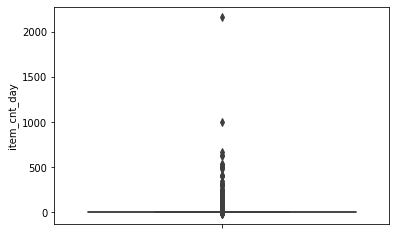

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(y='item_cnt_day', data=train)

 - 이상치가 많아서 박스 모양이 안나옴
 - 이상치의 기준은 실험적으로 판단

#### 판매가(상품 가격)

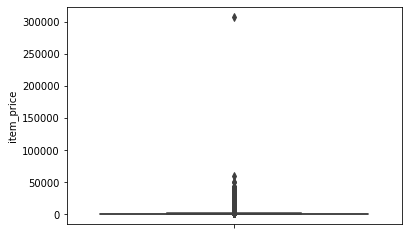

In [15]:
sns.boxplot(y='item_price', data=train)

 - 300,000루블이 넘는 판매가로 인해 박스플롯 모양 이상
 - 50,000루블 이상은 이상치로 판단하여 제거

#### 그룹화
 - 특정 피처를 기준으로 그룹화하여 집곗값을 구한다 : groupby()

In [16]:
train.groupby('date_block_num') # 그룹화된 객체 : iterable 하다

In [17]:
len(train.groupby('date_block_num')) # 34개의 그룹으로 구성됨

34

In [ ]:
train.groupby('date_block_num').get_group(0) # 그룹별로 출력 가능

In [19]:
train.groupby('date_block_num').aggregate({'item_cnt_day':sum}).head()

,item_cnt_day
date_block_num,
0,131479.0
1,128090.0
2,147142.0
3,107190.0
4,106970.0


In [24]:
group = train.groupby('date_block_num').agg({'item_cnt_day':sum}) # 그룹별로 'item_cnt_day'피처 값의 sum을 구하라
group.reset_index() # 인덱스 재설정 : 원본 데이터를 변화시키지 않음

,date_block_num,item_cnt_day
0,0,131479.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0
5,5,125381.0
6,6,116966.0
7,7,125291.0
8,8,133332.0
9,9,127541.0


#### 월별 판매량


[Text(0, 0.5, 'Monthly item counts'),
 Text(0.5, 0, 'Date block number'),
 Text(0.5, 1.0, 'Distribution of monthly item counts by date block number')]

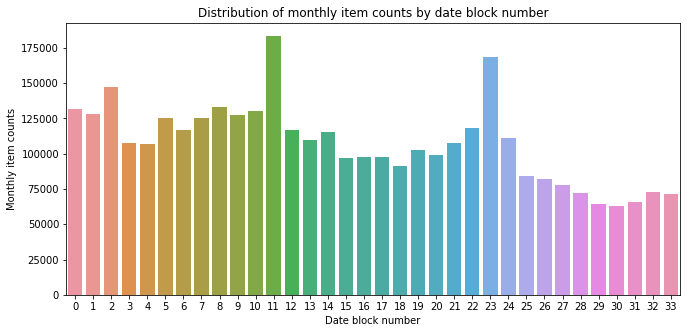

In [26]:
figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

# 월별 총 상품 판매량
group_month_sum = train.groupby('date_block_num').agg({'item_cnt_day':sum})
group_month_sum = group_month_sum.reset_index()

# 월별 총 상품 판매량 막대 그래프
sns.barplot(x='date_block_num', y='item_cnt_day', data=group_month_sum)
# 그래프 제목, x축 라벨, y축 라벨 설정
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number',
       ylabel='Monthly item counts')

 - 11, 23은 각각 2013년 12월, 2014년 12월이며, 연말이라 판매량이 많은것으로 추정

#### 상품분류별 판매량

In [27]:
train['item_category_id'].nunique() # 상품분류는 총 84개

84

 - 84개는 막대 그래프로 한번에 표현하기에는 너무 많으므로 월간 판매량이 10,000개를 초과하는 상품분류만 추출해서 plot

[Text(0, 0.5, 'Total item counts'),
 Text(0.5, 0, 'item category ID'),
 Text(0.5, 1.0, 'Distribution of total item counts by item category id')]

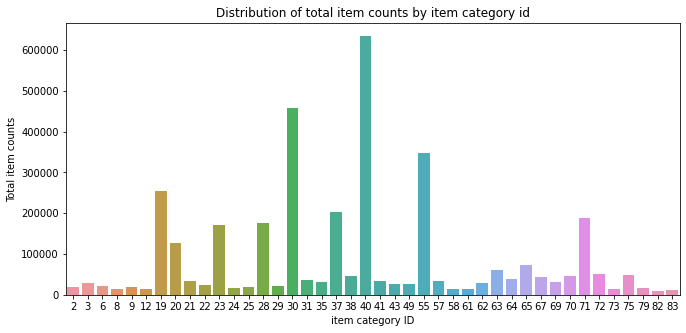

In [29]:
figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

# 상품분류별 총 상품 판매량
group_cat_sum = train.groupby('item_category_id').agg({'item_cnt_day':sum})
group_cat_sum = group_cat_sum.reset_index()

# 월간 판매량이 10,000개를 초과하는 상품분류만 추출
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_day'] > 10000]

# 월별 총 상품 판매량 막대 그래프
sns.barplot(x='item_category_id', y='item_cnt_day', data=group_cat_sum)
# 그래프 제목, x축 라벨, y축 라벨 설정
ax.set(title='Distribution of total item counts by item category id',
       xlabel='item category ID',
       ylabel='Total item counts')

 - ID 40, 30, 55 상품분류가 많이 팔림

#### 상점별 판매량
 - 상점개수는 60개
 - 판매량이 10,000개를 초과하는 상점만 나타냄

[Text(0, 0.5, 'Total item counts'),
 Text(0.5, 0, 'Date block number'),
 Text(0.5, 1.0, 'Distribution of total item counts by shop id')]

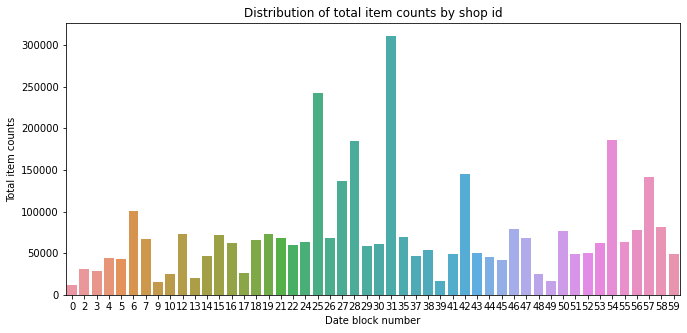

In [32]:
figure, ax = plt.subplots()
figure.set_size_inches(11, 5)

# 상품분류별 총 상품 판매량
group_shop_sum = train.groupby('shop_id').agg({'item_cnt_day':sum})
group_shop_sum = group_shop_sum.reset_index()

# 월간 판매량이 10,000개를 초과하는 상품분류만 추출
group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_day'] > 10000]

# 월별 총 상품 판매량 막대 그래프
sns.barplot(x='shop_id', y='item_cnt_day', data=group_shop_sum)
# 그래프 제목, x축 라벨, y축 라벨 설정
ax.set(title='Distribution of total item counts by shop id',
       xlabel='Date block number',
       ylabel='Total item counts')

 - 7~8개 상점이 다른 상점보다 많이 판매하는 양상